In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    Dropout,
    Flatten,
    BatchNormalization,
    LeakyReLU,
    concatenate,
)
from tensorflow.keras.optimizers import (
    SGD,
    Adam,
)
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

### Load data

Either load collection of climate indices directly from GitHub release. Or use local version of csv output file.

In [2]:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2022.09.09.1/climate_indices.csv"
)
climind = pd.read_csv(data_url)
#climind = pd.read_csv('../outpath/climate_indices.csv')
climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]
climind

index                  AMO   ENSO_12    ENSO_3   ENSO_34    ENSO_4    NAO_PC  \
model year month                                                               
CESM  1    1     -0.045584  0.878723  1.793537  2.277095  1.539571  1.494980   
           2     -0.055288  0.871110  1.725915  1.881192  1.460391  0.628604   
           3      0.000295  0.641493  1.292365  1.510816  1.266292  1.332836   
           4      0.017316  0.373644  0.930377  1.034762  0.775709  0.226980   
           5      0.031327 -0.038862  0.335949  0.702846  0.743190  0.995570   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8      0.178689  0.522490  1.009402  1.137735  1.011215  0.906418   
           9      0.098525  0.310882  0.931236  1.269963  1.355198  0.669222   
           10     0.012815  0.201341  0.842481  1.186615  1.407205  0.515824   
           11    -0.028865  0.250733  0.882067  1.289584  1.747254 -0.928136   
           12    -0.006059  0.284155  0.622142  1.097104  1.292274 -0.762554   

index               NAO_ST        NP    PDO_PC  PREC_SAHEL  ...   SSS_ENA  \
model year month                                            ...             
CESM  1    1      1.571751 -0.624027  0.354552   -0.000226  ...  0.377755   
           2      1.635490 -0.794662  0.391417   -0.002575  ...  0.088257   
           3      0.489595 -1.425871  0.566098   -0.095461  ...  0.121279   
           4      0.473761 -0.272417  0.879974   -0.121519  ...  0.204674   
           5      2.401551 -0.381626  1.086773    0.400654  ... -0.174217   
...                    ...       ...       ...         ...  ...       ...   
FOCI  1000 8      1.207901 -0.204993 -0.748606    0.684613  ... -0.903461   
           9      1.404237  0.132056 -0.420135    0.739803  ... -1.069282   
           10     1.190851 -0.353718 -0.232508   -0.029205  ... -1.003289   
           11    -1.419175  1.089200 -0.381073   -0.004869  ... -0.674776   
           12    -0.685174  0.324010 -0.595900    0.072165  ... -0.616161   

index               SSS_NA    SSS_SA   SSS_WNA  SST_ESIO  SST_HMDR   SST_MED  \
model year month                                                               
CESM  1    1      0.361125 -0.650658  0.001022  0.483008  0.070793  0.032231   
           2      0.084034 -0.552023 -0.027617  0.602004  0.141540  0.036850   
           3      0.091827 -0.383901 -0.117263  0.359004  0.199297 -0.004955   
           4      0.097583 -0.218266 -0.047506  0.066606  0.152572 -0.107935   
           5     -0.365616 -0.188526 -0.354763  0.090692  0.205236 -0.138338   
...                    ...       ...       ...       ...       ...       ...   
FOCI  1000 8     -0.571605 -0.096008  0.587311 -0.194002  0.054469  0.091777   
           9     -0.607013 -0.043860  0.796168 -0.228907  0.053131  0.274988   
           10    -0.415460  0.055235  0.992450  0.001155 -0.029871  0.225920   
           11    -0.078932  0.135558  0.973861  0.029547 -0.074635  0.077247   
           12    -0.049702  0.477039  0.880939  0.191145 -0.241239  0.089911   

index              SST_TNA   SST_TSA  SST_WSIO  
model year month                                
CESM  1    1      0.038024  0.526206 -0.316788  
           2      0.070549  0.416427 -0.276104  
           3      0.160956  0.378252 -0.186131  
           4      0.023744  0.319001 -0.130724  
           5     -0.041518  0.126895 -0.144448  
...                    ...       ...       ...  
FOCI  1000 8      0.026577  0.050525  0.123432  
           9      0.030738 -0.008511  0.028916  
           10    -0.087775 -0.100116  0.055975  
           11    -0.167492 -0.162180  0.172732  
           12    -0.279017  0.093415 -0.048286  

[23988 rows x 29 columns]

### Standardise data

All indices have **zero mean** be definition. But need to divide by standard deviation to make sure, all indices have **unit variance**.

In [49]:
# Separate data by model:
climind_FOCI = climind.loc[('FOCI')]
climind_CESM = climind.loc[('CESM')]

# Compute mean and standard deviation:
mean_FOCI = np.mean(climind_FOCI,axis=0)
mean_CESM = np.mean(climind_CESM,axis=0)
std_FOCI = np.std(climind_FOCI,axis=0)
std_CESM = np.std(climind_CESM,axis=0)

# Standardise data:
climind_FOCI_norm = (climind_FOCI - mean_FOCI) / std_FOCI
climind_CESM_norm = (climind_CESM - mean_CESM) / std_CESM

# Check result:
print("Mean values for FOCI indices:\n", np.mean(climind_FOCI_norm,axis=0))
print("\nStd Dev for FOCI indices:\n", np.std(climind_FOCI_norm,axis=0))
print("\nMean values for CESM indices:\n", np.mean(climind_CESM_norm,axis=0))
print("\nStd Dev for CESM indices:\n", np.std(climind_CESM_norm,axis=0))

Mean values for FOCI indices:
 index
AMO            1.894781e-17
ENSO_12       -1.184238e-17
ENSO_3         1.657933e-17
ENSO_34        1.421085e-17
ENSO_4         1.894781e-17
NAO_PC        -1.776357e-18
NAO_ST        -7.401487e-18
NP             8.881784e-18
PDO_PC        -2.368476e-18
PREC_SAHEL     0.000000e+00
SAM_PC        -8.289665e-18
SAM_ZM        -1.539509e-17
SAT_N_ALL      4.736952e-18
SAT_N_LAND    -5.921189e-18
SAT_N_OCEAN    3.315866e-17
SAT_S_ALL     -9.473903e-18
SAT_S_LAND     4.736952e-18
SAT_S_OCEAN    0.000000e+00
SOI            1.361874e-17
SSS_ENA       -1.894781e-17
SSS_NA        -4.736952e-17
SSS_SA        -1.894781e-17
SSS_WNA       -9.473903e-18
SST_ESIO      -2.605323e-17
SST_HMDR       1.894781e-17
SST_MED        2.842171e-17
SST_TNA        4.736952e-18
SST_TSA       -3.552714e-17
SST_WSIO      -9.473903e-18
dtype: float64

Std Dev for FOCI indices:
 index
AMO            1.0
ENSO_12        1.0
ENSO_3         1.0
ENSO_34        1.0
ENSO_4         1.0
NAO_PC 

### Define custom functions

- **split_sequence** to split data into secuences of specified length
- **set_CNN_fc** to set up CNN/fc model

In [58]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [220]:
# Define function to set up CNN/fc model:
def set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, 
           n_epochs, batch_size, learning_rate, loss_function):
    """
    Sets up CNN/fc model. Can be used for multi-run experiments.
    
    Parameters:
    ===========
    CNN_filters: Array of integer numbers to specify the number of feature maps in all CNN layers.
    CNN_kernel_sizes: Array of integer numbers to specify the filter sizes in all CNN layers.
    fc_units: Array of integer numbers to specify the number of units in all hidden fc layers.
    n_epochs: Integer number to specify the number of epochs for a single run.
    batch_size: Integer number to specify the batch size used for training the model.
    learning_rate: Floating point number to set the learning rate for the optimizer.
    loss_function: String ('mse', 'custom_mse', 'custom_loss') to choose the loss function.
    
    Returns:
    ========
    model
    
    """
    
    # Start model definition:
    model = Sequential()
    
    # Add input layer:
    input_shape = (input_length, len(input_features))
    model.add(Input(shape=input_shape))
    
    # Add CNN layer(s):
    for i in range(len(CNN_filters)):
        model.add(Conv1D(filters=CNN_filters[i], kernel_size=CNN_kernel_sizes[i], strides=1,
                         kernel_initializer=weight_init, bias_initializer = bias_init))
        model.add(BatchNormalization())
        model.add(LeakyReLU(alpha=0.3))
        
        # Add max pooling, if input_length is equal or above 40d to limit number of trainable parameters:
        if input_length >= 40:
            model.add(MaxPooling1D(pool_size=2))
    
    # Flatten CNN output:
    model.add(Flatten())
    
    # Add hidden fc layer(s):
    for i in range(len(fc_units)):
        model.add(Dense(units=fc_units[i], activation = 'sigmoid',
                        kernel_initializer=weight_init, bias_initializer = bias_init))
    
    # Add output unit:
    model.add(Dense(units=1, name = "output", activation = 'linear',
                    kernel_initializer=weight_init, bias_initializer = bias_init))

    # Compile model with desired loss function:
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss_function)
   
    return model

### Pre-process inputs and targets, define model parameters, single-run model: CNN/fc model

- Extract North and South Atlantic sea-surface salinity anomaly indices ("SSS_NA", "SSS_SA") as **input features**.
- Select Sahel precipitation anomaly index ("PREC_SAHEL") as **continuous target**.

In [221]:
## Set parameters:

# Data pre-processing:

#input_features = ['SSS_NA', 'SSS_SA'] # Only North and South Atlantic sea-surface salinity anomalies.
input_features = climind_FOCI_norm.columns[climind_FOCI_norm.columns != 'PREC_SAHEL'] # All indices except target!
target_feature = 'PREC_SAHEL'
input_length = 24 # months

# Model parameters:
weight_init = tfi.glorot_uniform() # Taken as default.
bias_init = tfi.Zeros() # Taken as default.
CNN_filters = [10,20]
CNN_kernel_sizes = [5,5]
fc_units = [20,10]
LSTM_units = [20,10]
n_epochs = 10
batch_size = 20
learning_rate = 0.001
loss_function = 'mse'

In [222]:
## Start with indices from FOCI model:

# Select specified input features and target feature and convert to numpy arrays:
inputs = np.array(climind_FOCI_norm[input_features])
targets = np.array(climind_FOCI_norm[target_feature])

# Split input values into sequences of specified input length:
inputs_split = split_sequence(inputs, input_length)

# Adjust targets: Cut first (input_length - 1) entries
target_cut = targets[input_length-1:]

# Reshape targets to have dimension (samples, 1):
target_cut = np.reshape(target_cut, (len(target_cut), 1))

In [223]:
## Split inputs and targets into train and validation sets (80:20):

# Get split point:
split = int(len(inputs_split) * 0.8)

train_input = inputs_split[:split]
val_input = inputs_split[split:]

train_target = target_cut[:split]
val_target = target_cut[split:]

# Check dimensions:
print("train_input shape (samples, time steps, features): ", train_input.shape)
print("val_input shape (samples, time steps, features): ", val_input.shape)
print("\ntrain_target shape (samples, features): ", train_target.shape)
print("val_target shape (samples, features): ", val_target.shape)

train_input shape (samples, time steps, features):  (9581, 24, 28)
val_input shape (samples, time steps, features):  (2396, 24, 28)

train_target shape (samples, features):  (9581, 1)
val_target shape (samples, features):  (2396, 1)


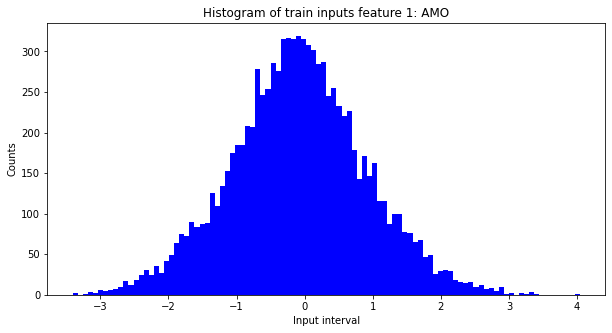

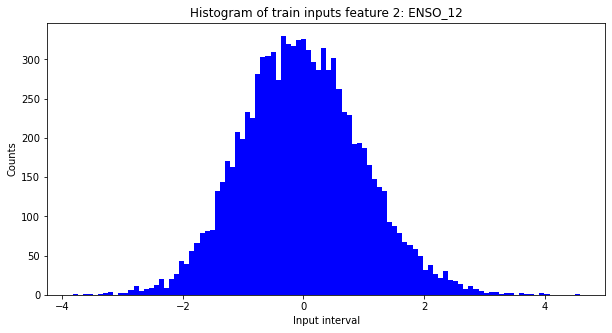

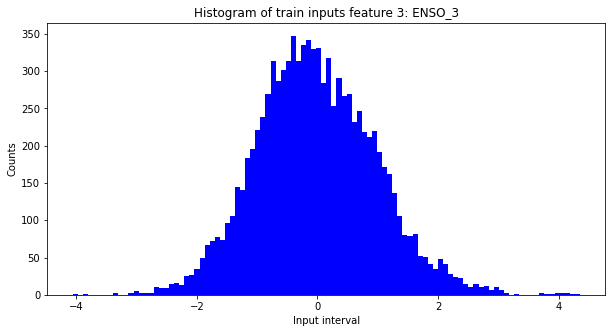

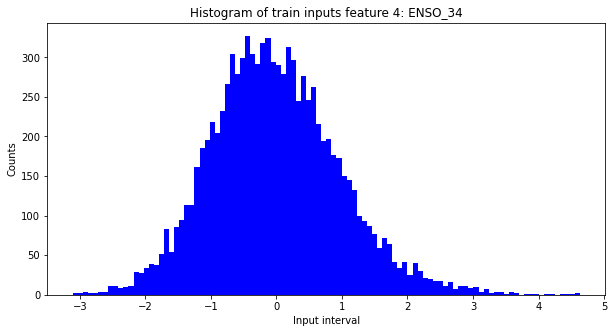

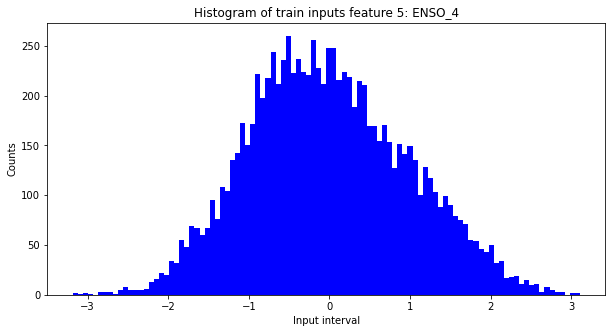

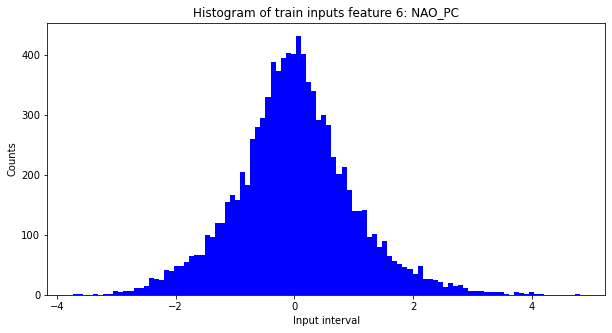

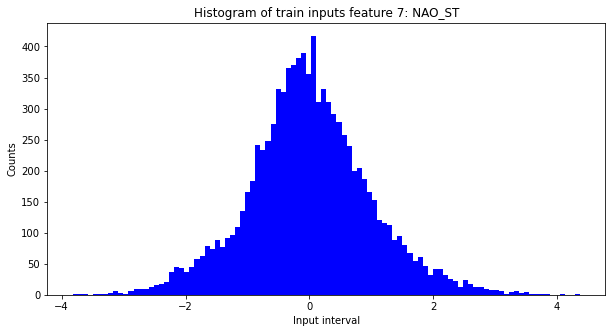

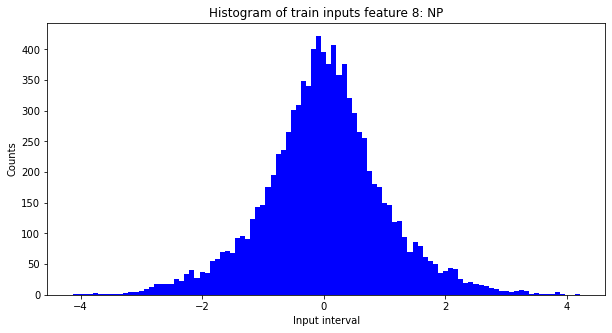

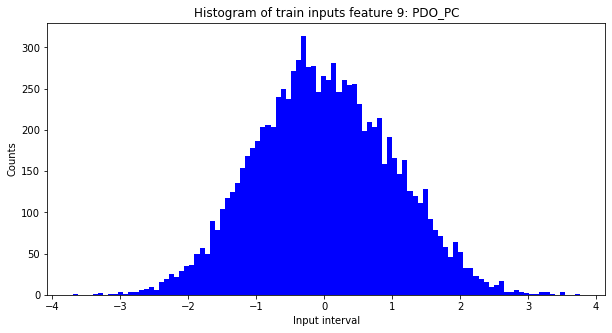

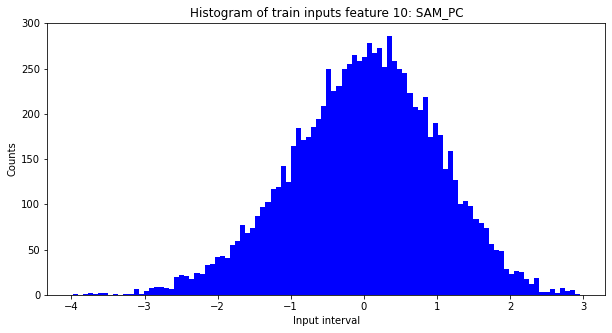

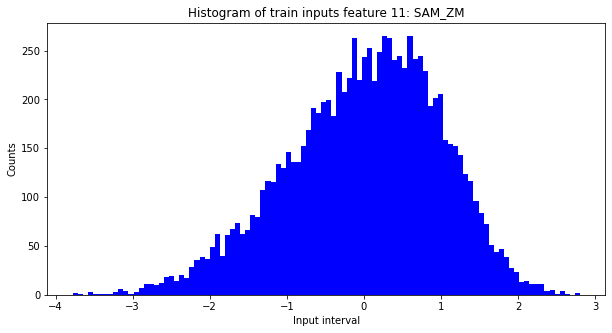

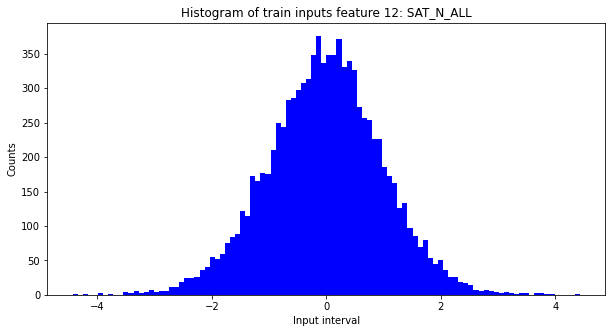

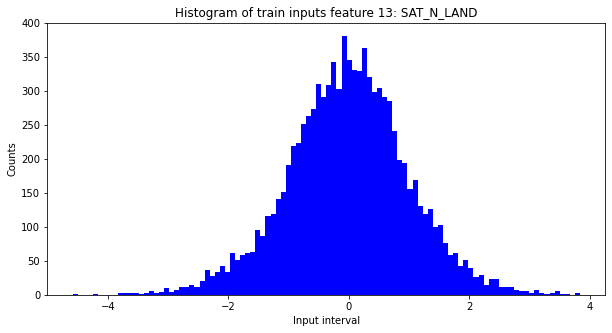

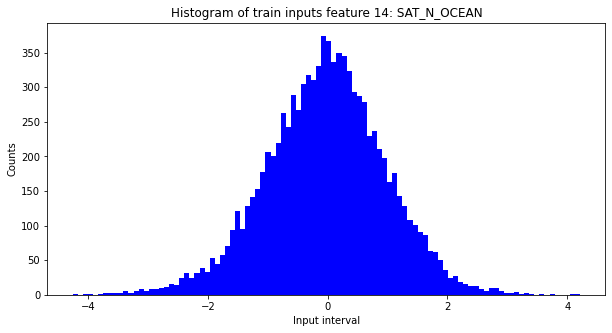

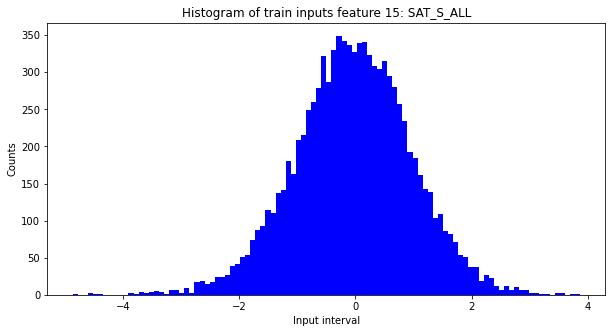

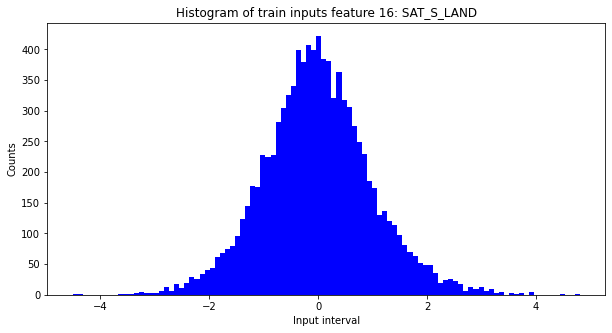

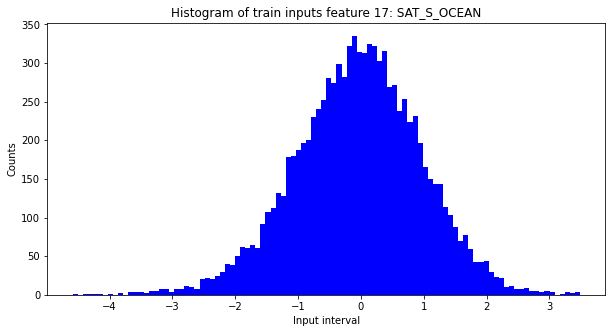

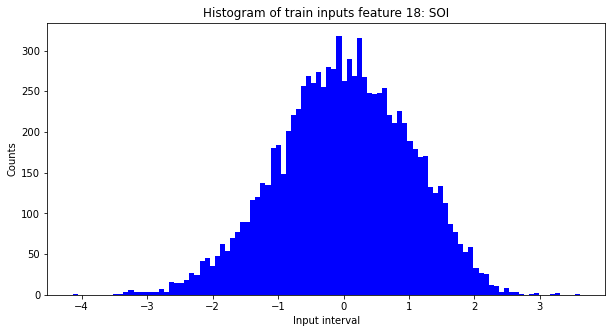

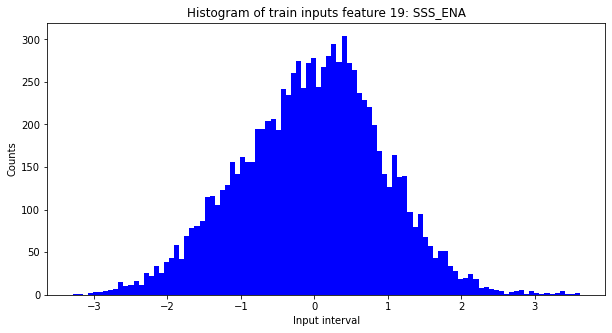

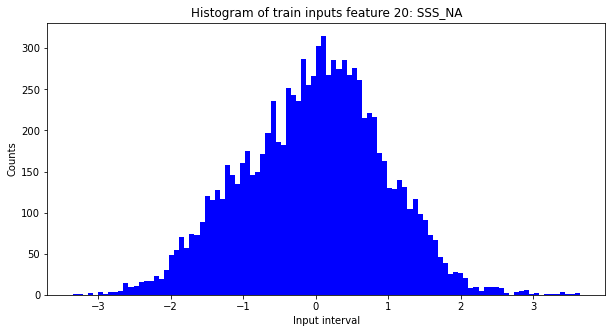

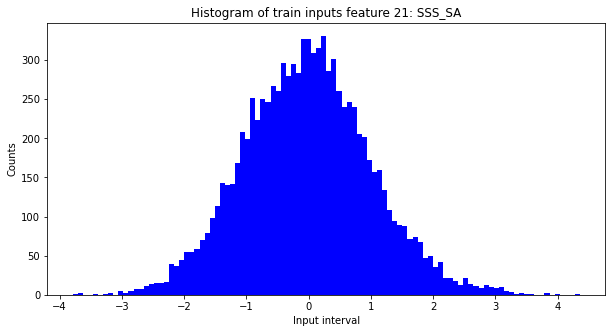

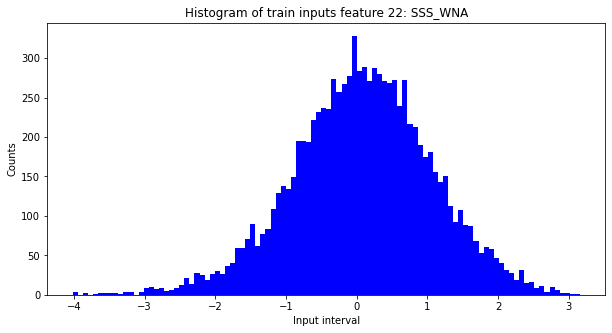

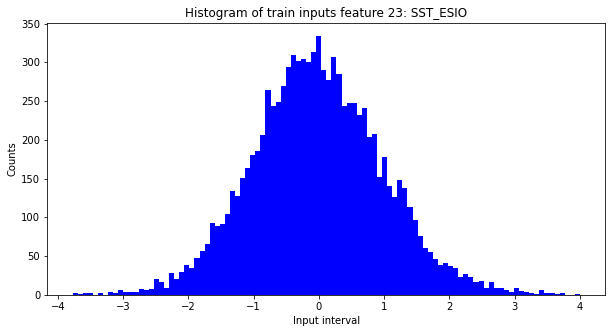

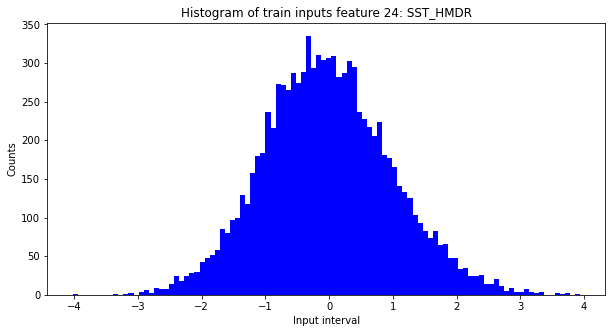

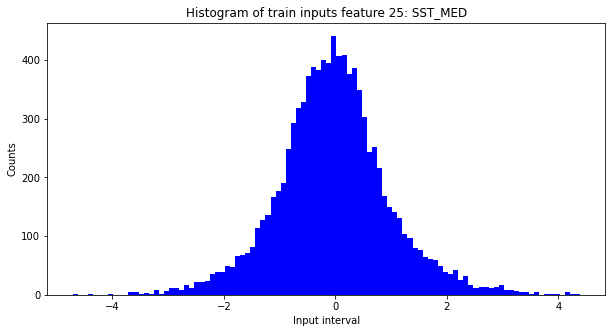

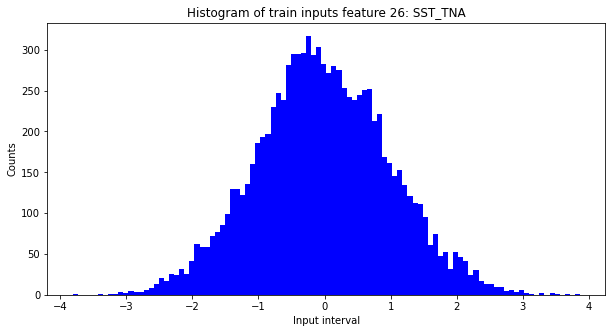

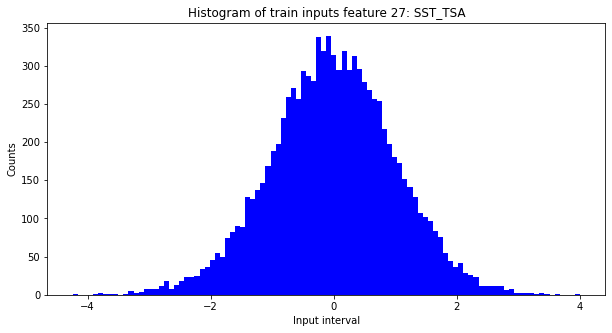

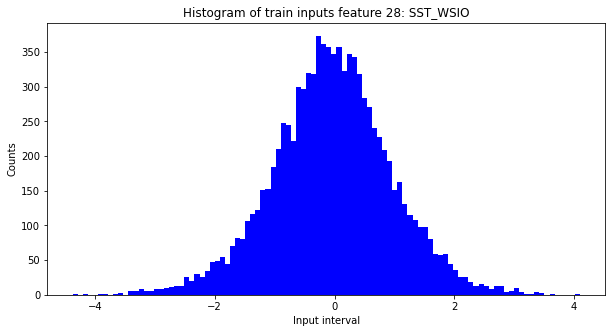

In [224]:
## Plot histogram of scaled inputs

# Loop over number of input features:
for feature in range(train_input.shape[-1]):
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(train_input[:,0,feature], nBins, color="blue")
    axes.set_xlabel("Input interval")
    axes.set_ylabel("Counts")
    axes.set_title("Histogram of train inputs feature " + str(feature+1) + ": " + input_features[feature])
    plt.show()

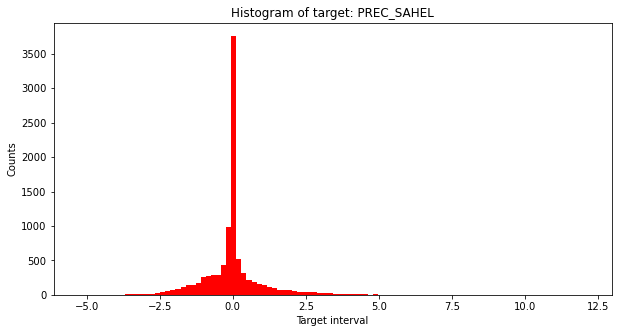

In [225]:
# Plot histogram of targets
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_target[:,0], nBins, color="red")
axes.set_xlabel("Target interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of target: " + target_feature)
plt.show()

### Predict Sahel Rainfall with CNN/fc model

In [226]:
# Set up compiled CNN/fc model:
model = set_CNN_fc(CNN_filters, CNN_kernel_sizes, fc_units, n_epochs, batch_size, learning_rate, loss_function)
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 20, 10)            1410      
_________________________________________________________________
batch_normalization_20 (Batc (None, 20, 10)            40        
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 20, 10)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16, 20)            1020      
_________________________________________________________________
batch_normalization_21 (Batc (None, 16, 20)            80        
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16, 20)            0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 320)             

In [227]:
# Train model on scaled inputs and un-scaled targets:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=2, validation_data=(val_input, val_target))

Epoch 1/10
480/480 - 1s - loss: 1.0255 - val_loss: 0.9128
Epoch 2/10
480/480 - 1s - loss: 0.9751 - val_loss: 0.8904
Epoch 3/10
480/480 - 1s - loss: 0.8605 - val_loss: 0.7428
Epoch 4/10
480/480 - 1s - loss: 0.7145 - val_loss: 0.6519
Epoch 5/10
480/480 - 1s - loss: 0.6445 - val_loss: 0.6537
Epoch 6/10
480/480 - 1s - loss: 0.5987 - val_loss: 0.6490
Epoch 7/10
480/480 - 1s - loss: 0.5686 - val_loss: 0.6415
Epoch 8/10
480/480 - 1s - loss: 0.5480 - val_loss: 0.6279
Epoch 9/10
480/480 - 1s - loss: 0.5187 - val_loss: 0.6365
Epoch 10/10
480/480 - 1s - loss: 0.5019 - val_loss: 0.6321


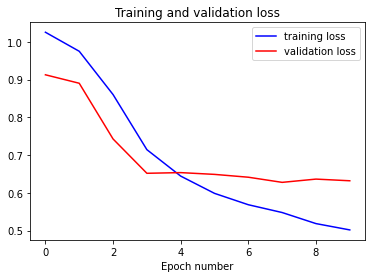

In [228]:
# Plot train and val_loss ('mse')
plt.plot(history.history['loss'], color = 'blue', label = 'training loss')
plt.plot(history.history['val_loss'], color = 'red', label = 'validation loss')
plt.xlabel('Epoch number')
#plt.ylim(0.6, 0.8)
plt.title('Training and validation loss')
plt.legend()
plt.show() 

In [229]:
# Get model predictions:
train_pred = model.predict(train_input)
val_pred = model.predict(val_input)

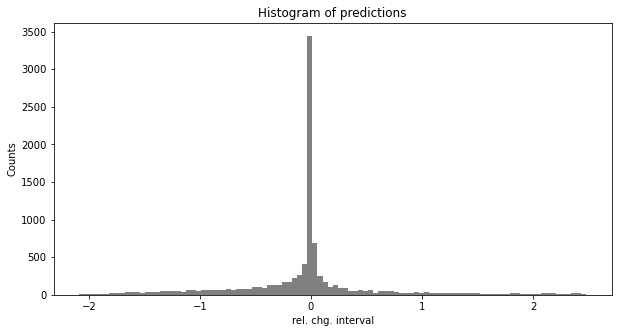

In [230]:
# Plot histogram of predictions
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(train_pred[:,0], nBins, color="grey")
axes.set_xlabel("rel. chg. interval")
axes.set_ylabel("Counts")
axes.set_title("Histogram of predictions")
plt.show()

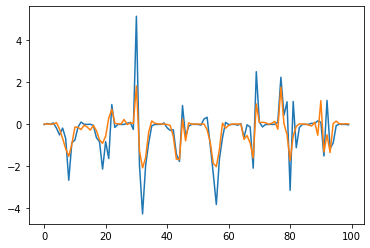

In [231]:
plt.plot(train_target[:100])
plt.plot(train_pred[:100])

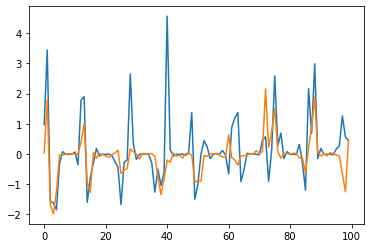

In [232]:
plt.plot(val_target[:100])
plt.plot(val_pred[:100])

In [233]:
print(np.corrcoef(np.stack([train_target[:,0], train_pred[:,0]])))
print(np.corrcoef(np.stack([val_target[:,0], val_pred[:,0]])))

[[1.         0.74706086]
 [0.74706086 1.        ]]
[[1.         0.57389535]
 [0.57389535 1.        ]]


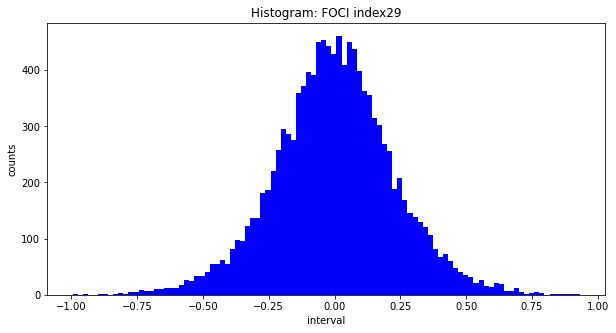

In [14]:
nBins = 100
fig, axes = plt.subplots(1, 1, figsize=(10,5))
axes.hist(climind_FOCI[:,i], nBins, color="blue")
axes.set_xlabel("interval")
axes.set_ylabel("counts")
axes.set_title("Histogram: FOCI index" + str(i+1))
plt.show()

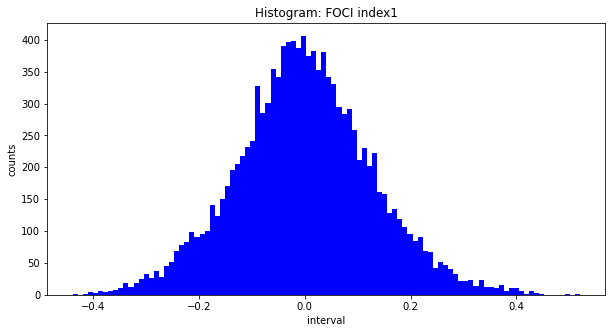

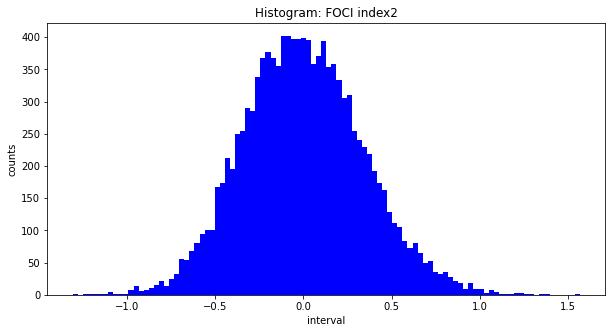

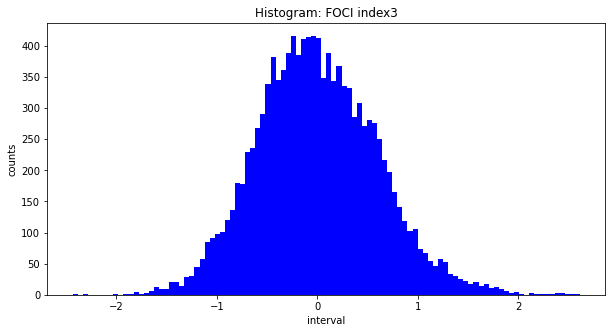

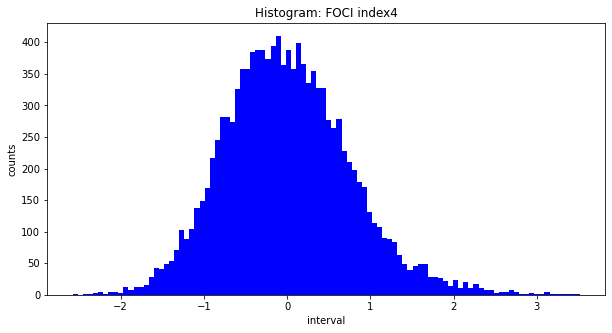

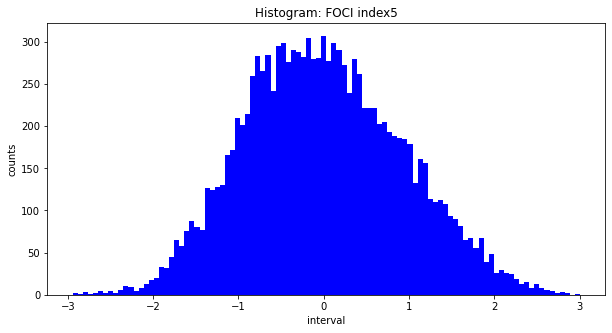

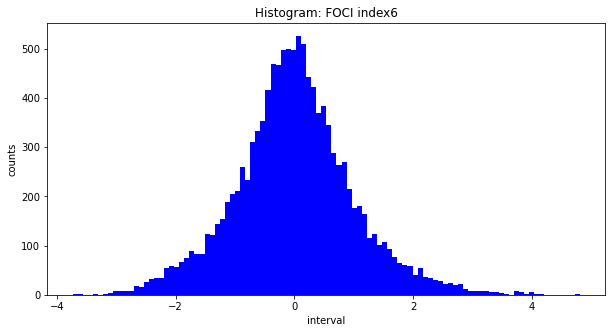

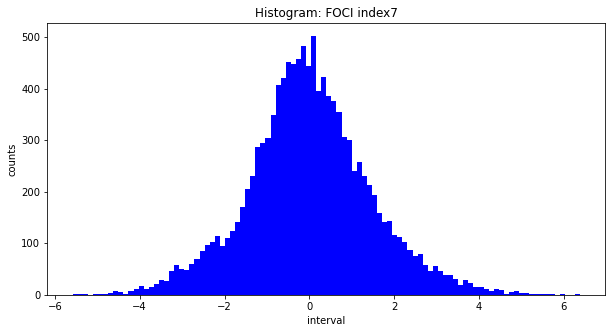

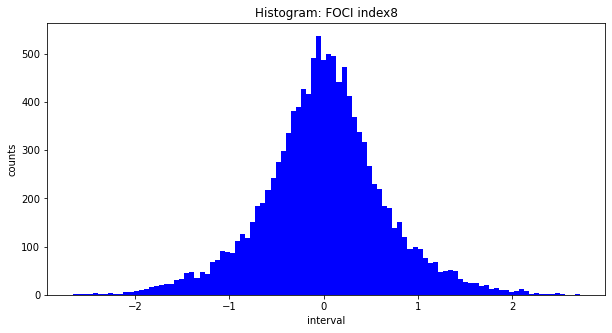

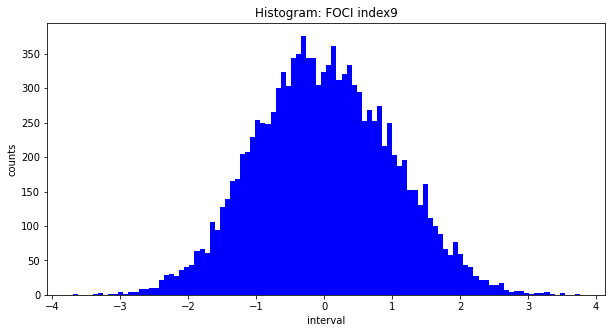

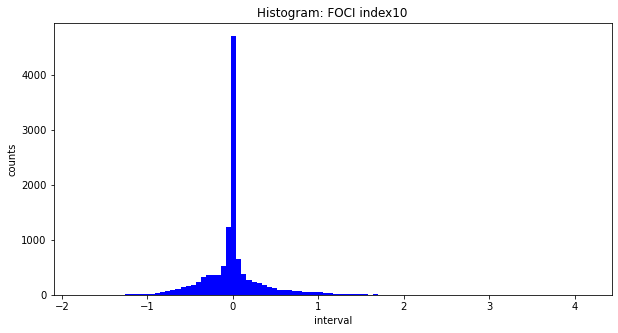

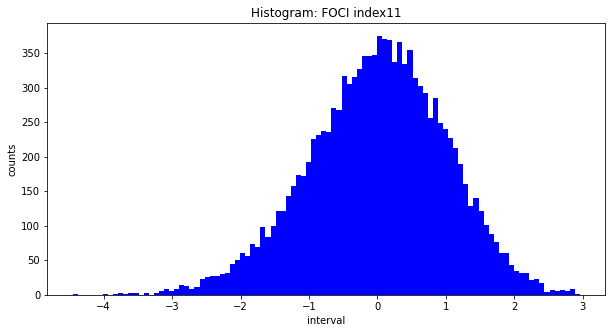

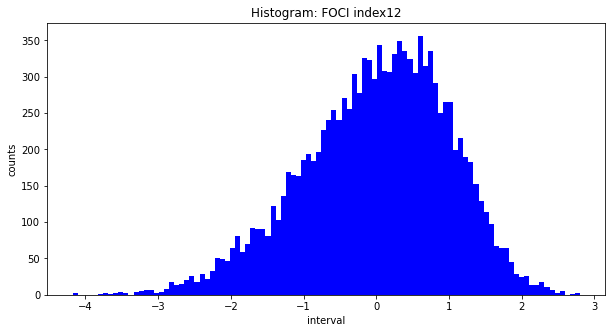

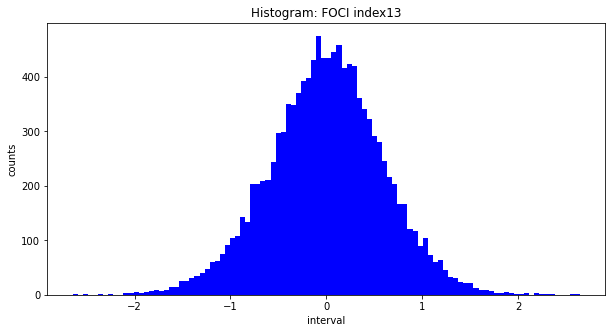

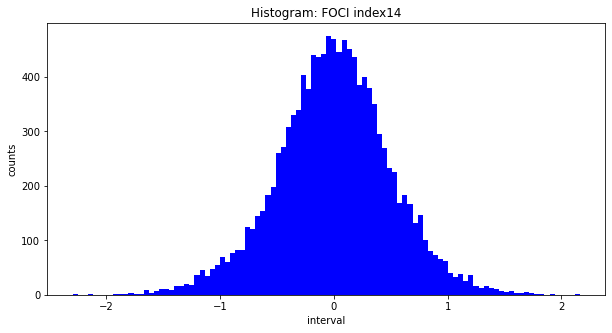

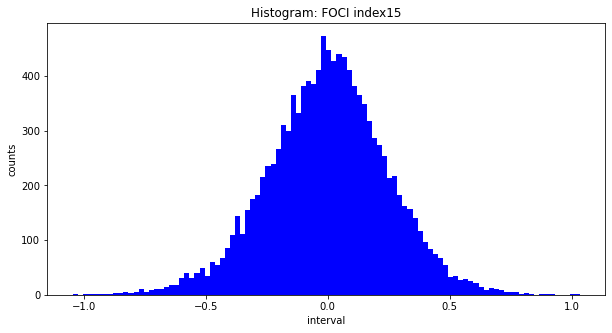

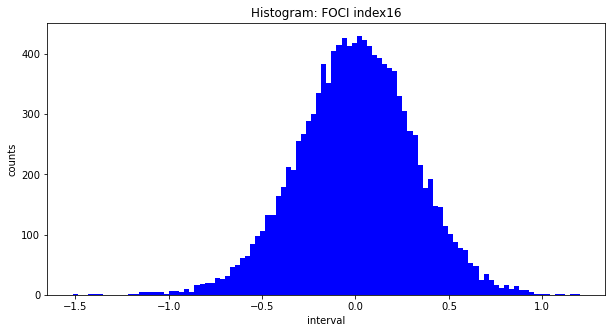

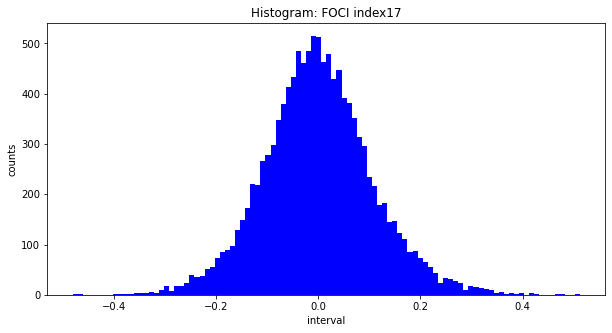

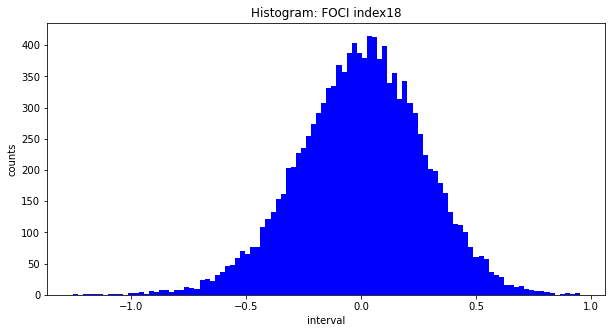

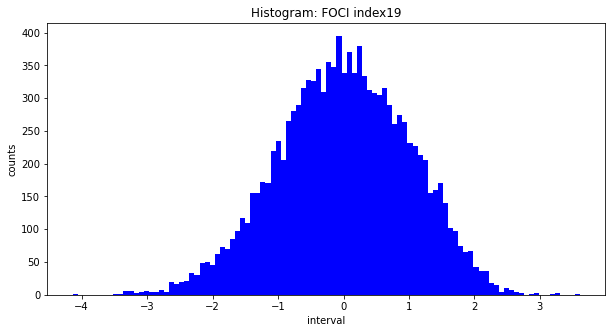

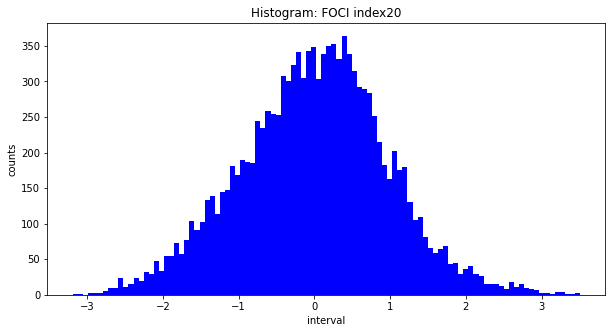

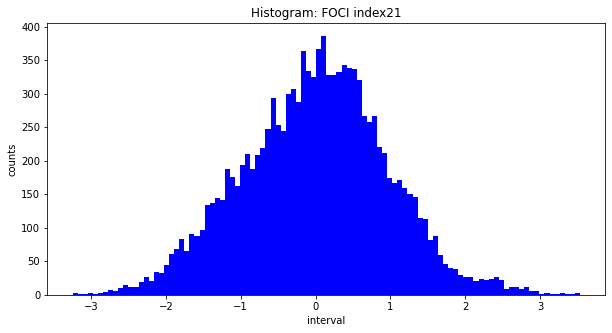

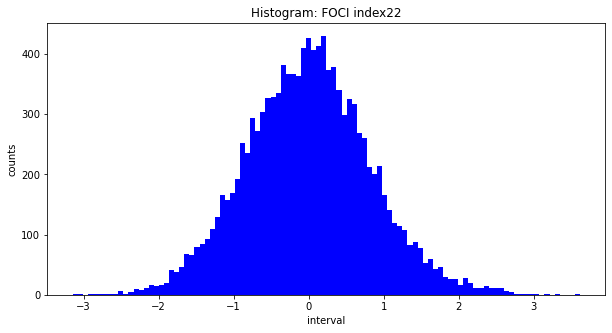

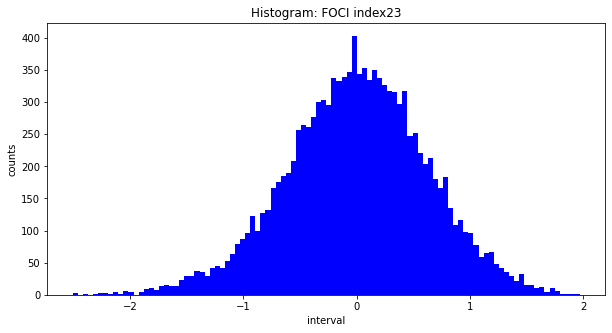

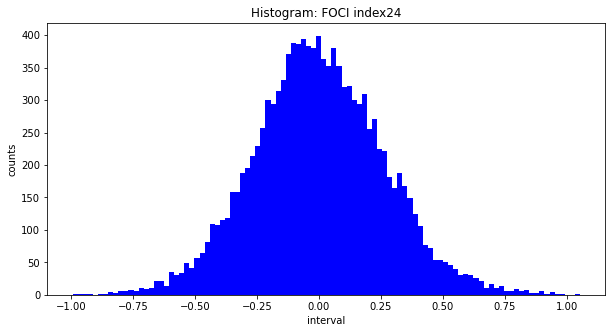

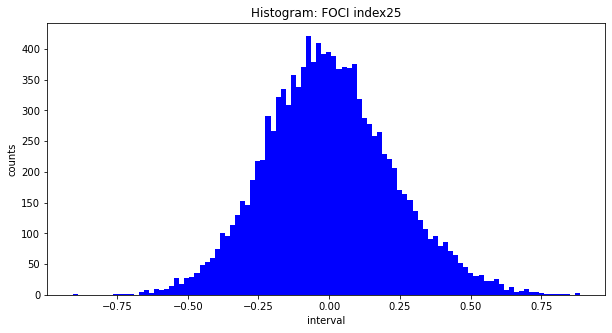

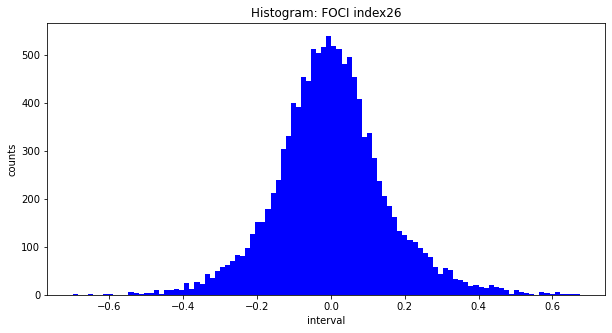

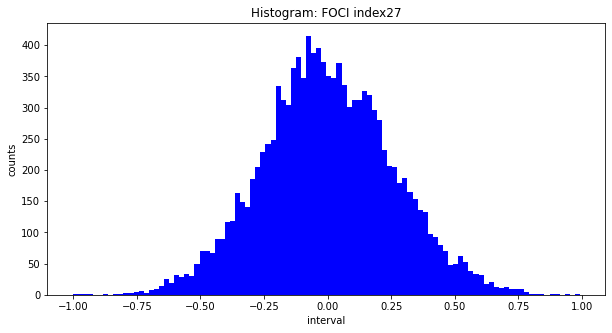

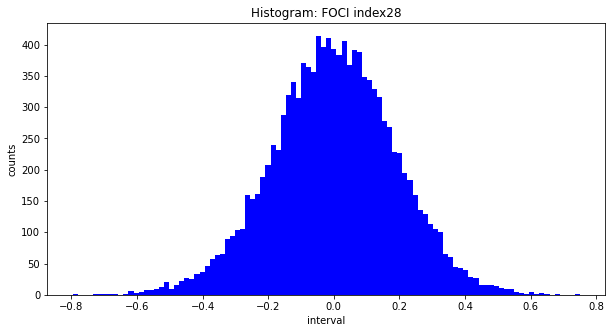

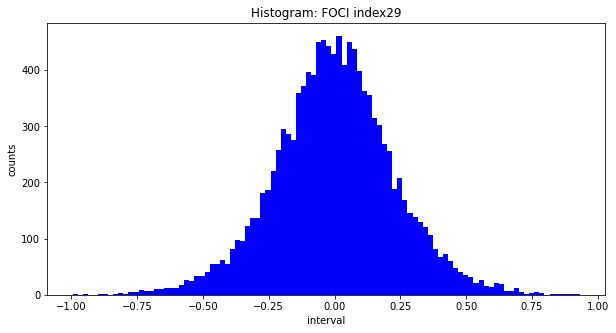

In [15]:
climind_FOCI = np.array(climind.loc[('FOCI')])
climind_CESM = np.array(climind.loc[('CESM')])

for i in range(climind_FOCI.shape[-1]):
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(climind_FOCI[:,i], nBins, color="blue")
    axes.set_xlabel("interval")
    axes.set_ylabel("counts")
    axes.set_title("Histogram: FOCI index" + str(i+1))
    plt.show()

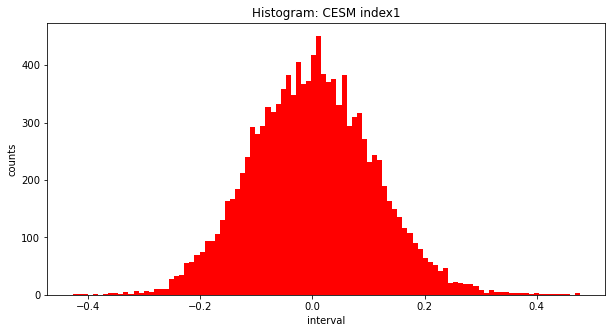

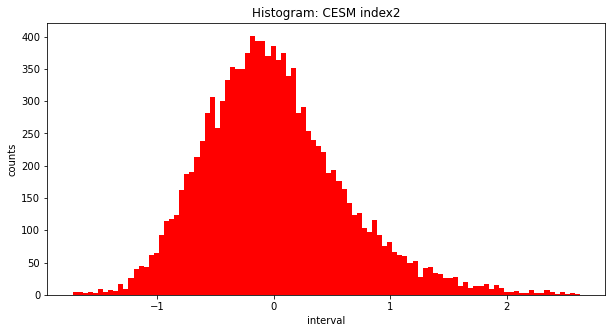

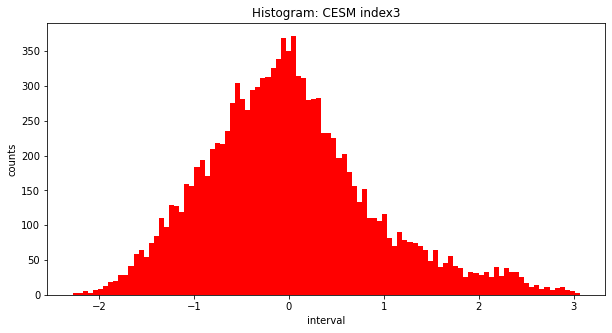

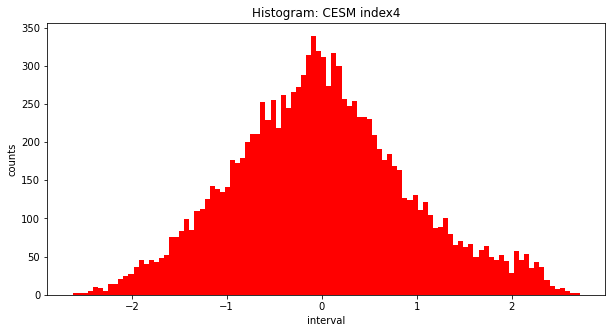

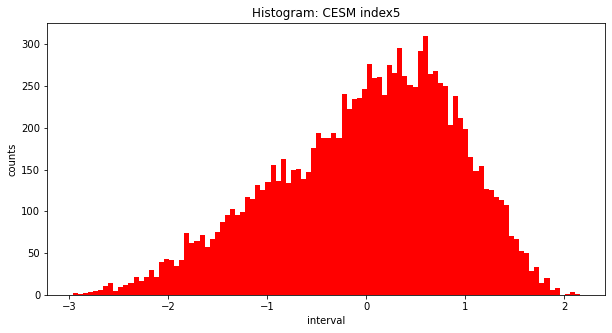

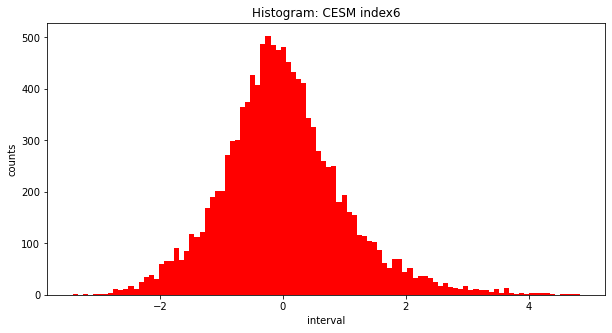

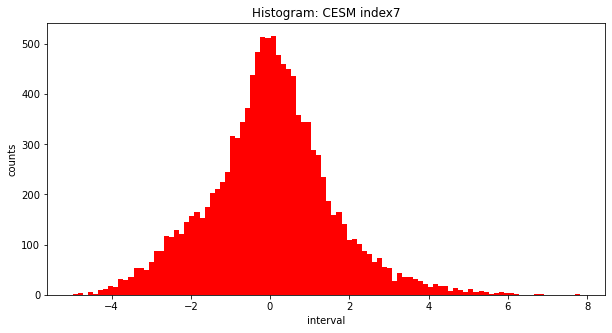

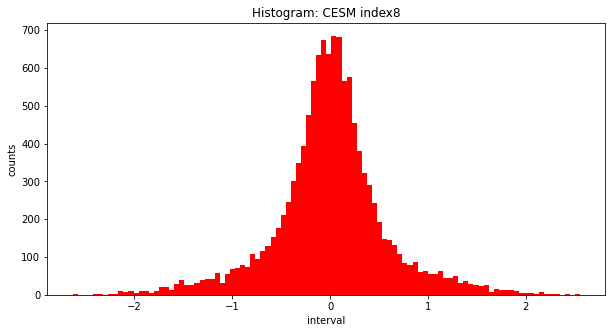

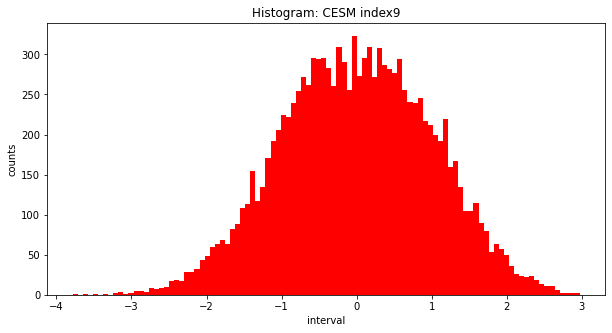

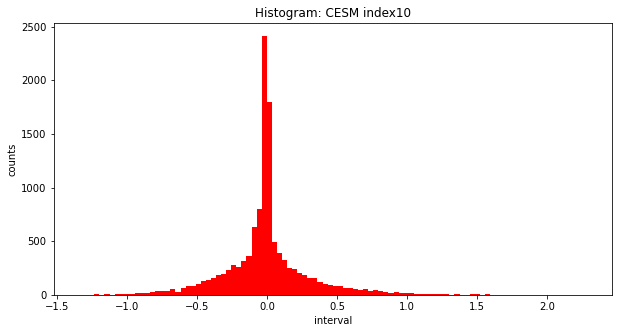

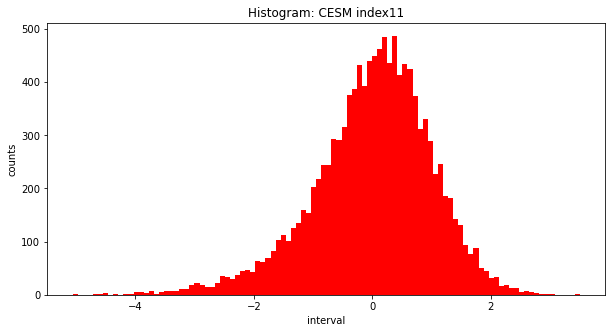

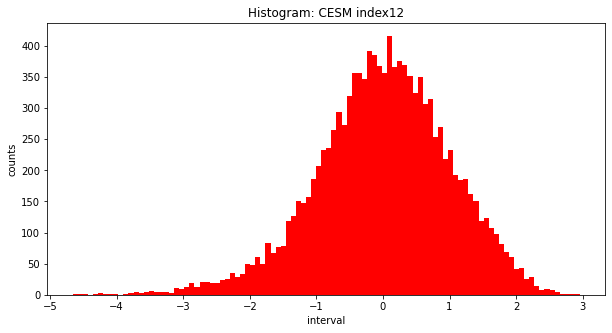

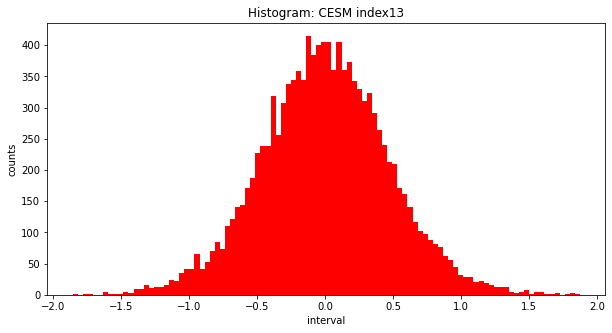

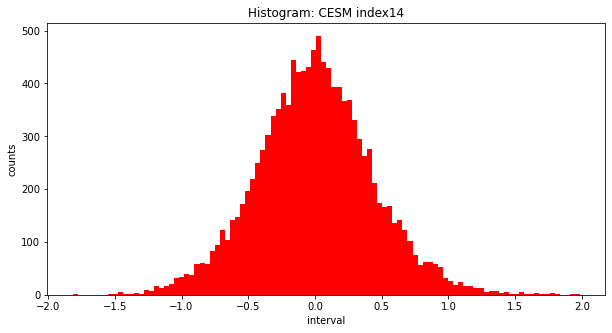

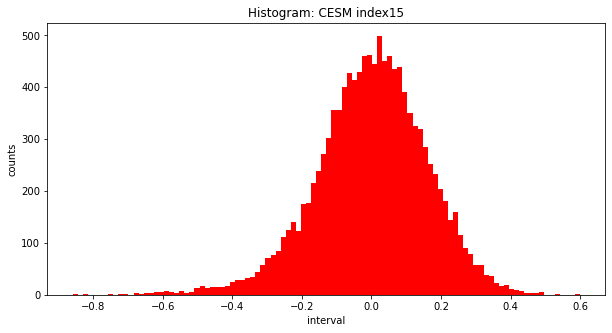

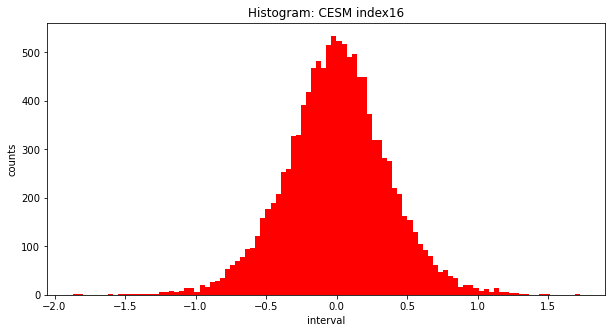

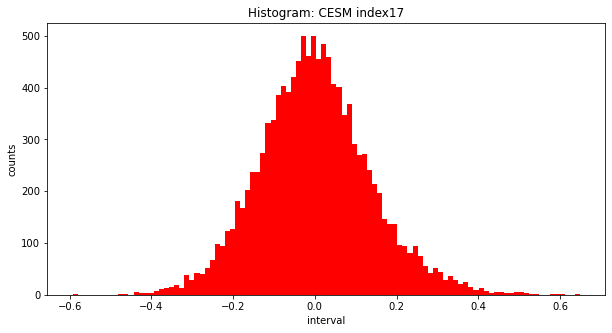

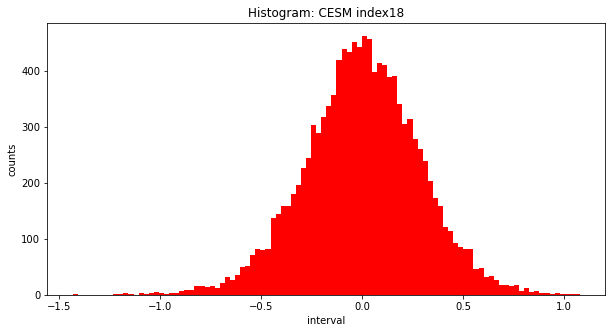

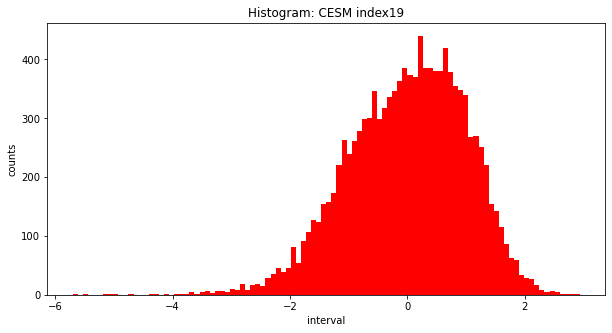

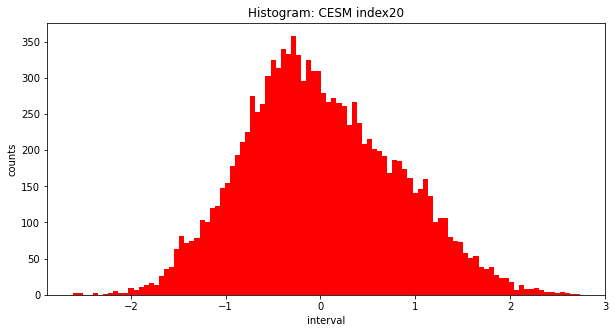

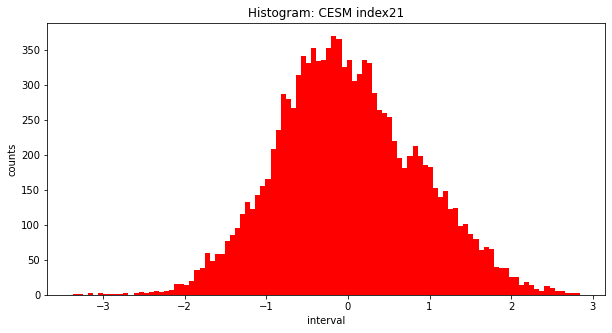

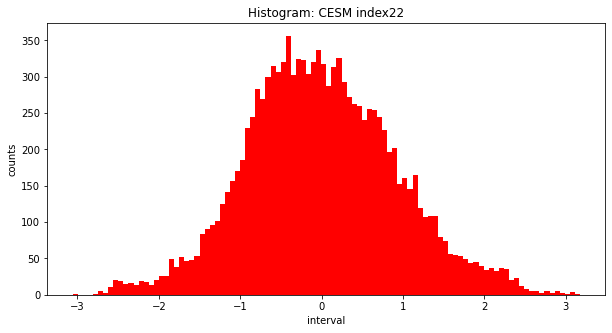

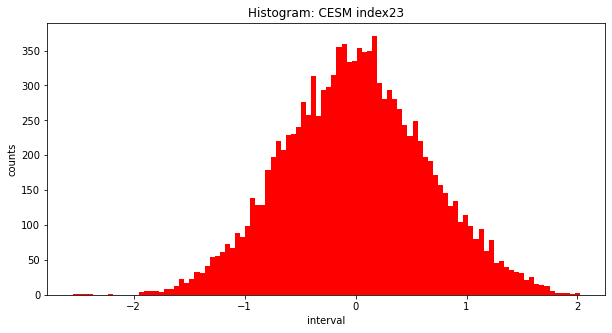

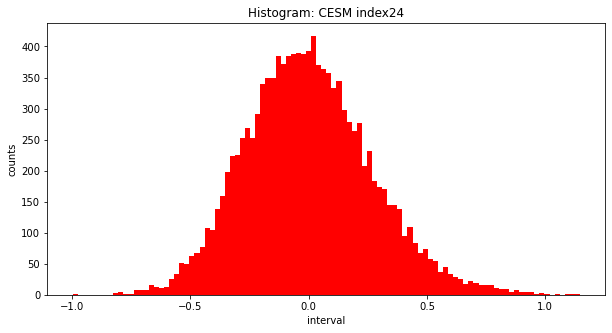

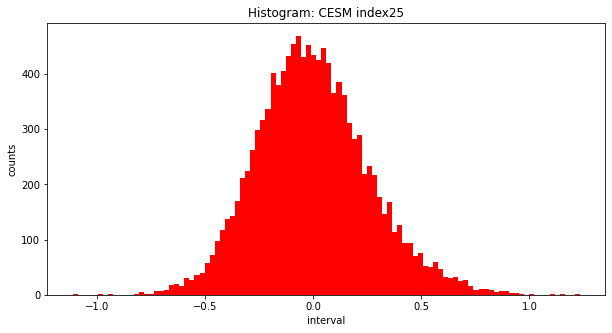

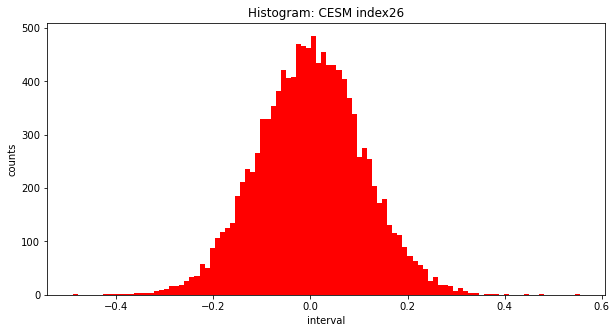

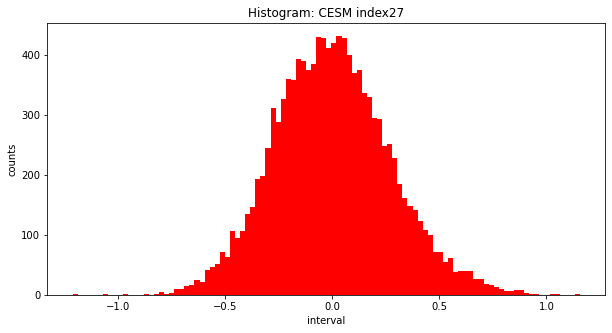

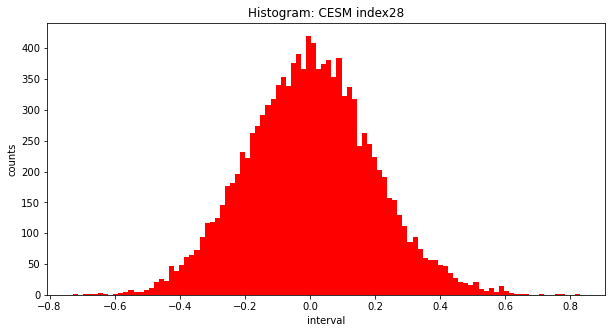

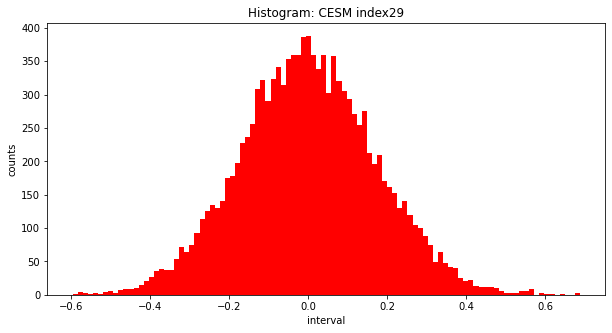

In [16]:
for i in range(climind_CESM.shape[-1]):
    nBins = 100
    fig, axes = plt.subplots(1, 1, figsize=(10,5))
    axes.hist(climind_CESM[:,i], nBins, color="red")
    axes.set_xlabel("interval")
    axes.set_ylabel("counts")
    axes.set_title("Histogram: CESM index" + str(i+1))
    plt.show()

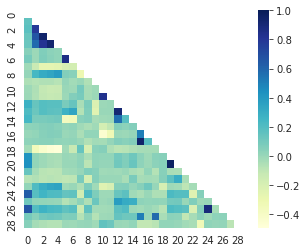

In [24]:
corr = np.corrcoef(climind_FOCI.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,  cmap="YlGnBu")
    plt.show()

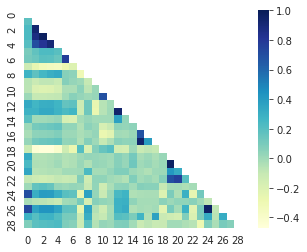

In [25]:
corr = np.corrcoef(climind_CESM.T)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=1, square=True,  cmap="YlGnBu")
    plt.show()